In [1]:
%load_ext autoreload
%autoreload 2

from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from data_modules import *
import torch.nn.functional as F
from ablation import Conv_Att_Wave_Net

plt.style.use('science')

# Wavelet

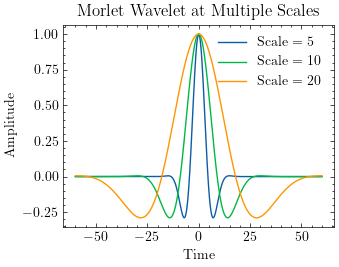

In [2]:
import numpy as np
import matplotlib.pyplot as plt

scales = [5, 10, 20]

plt.figure()

t_min, t_max = -3 * max(scales), 3 * max(scales)
t = np.arange(t_min, t_max + 0.1, 0.1)

for scale in scales:
    wavelet = np.cos(1.75 * t / scale) * np.exp(-t**2 / (2 * scale**2))
    plt.plot(t, wavelet, label=f'Scale = {scale}')

plt.title('Morlet Wavelet at Multiple Scales')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
# plt.grid(True)
plt.savefig('doc/images/wavelet-scales.pdf', dpi=600)

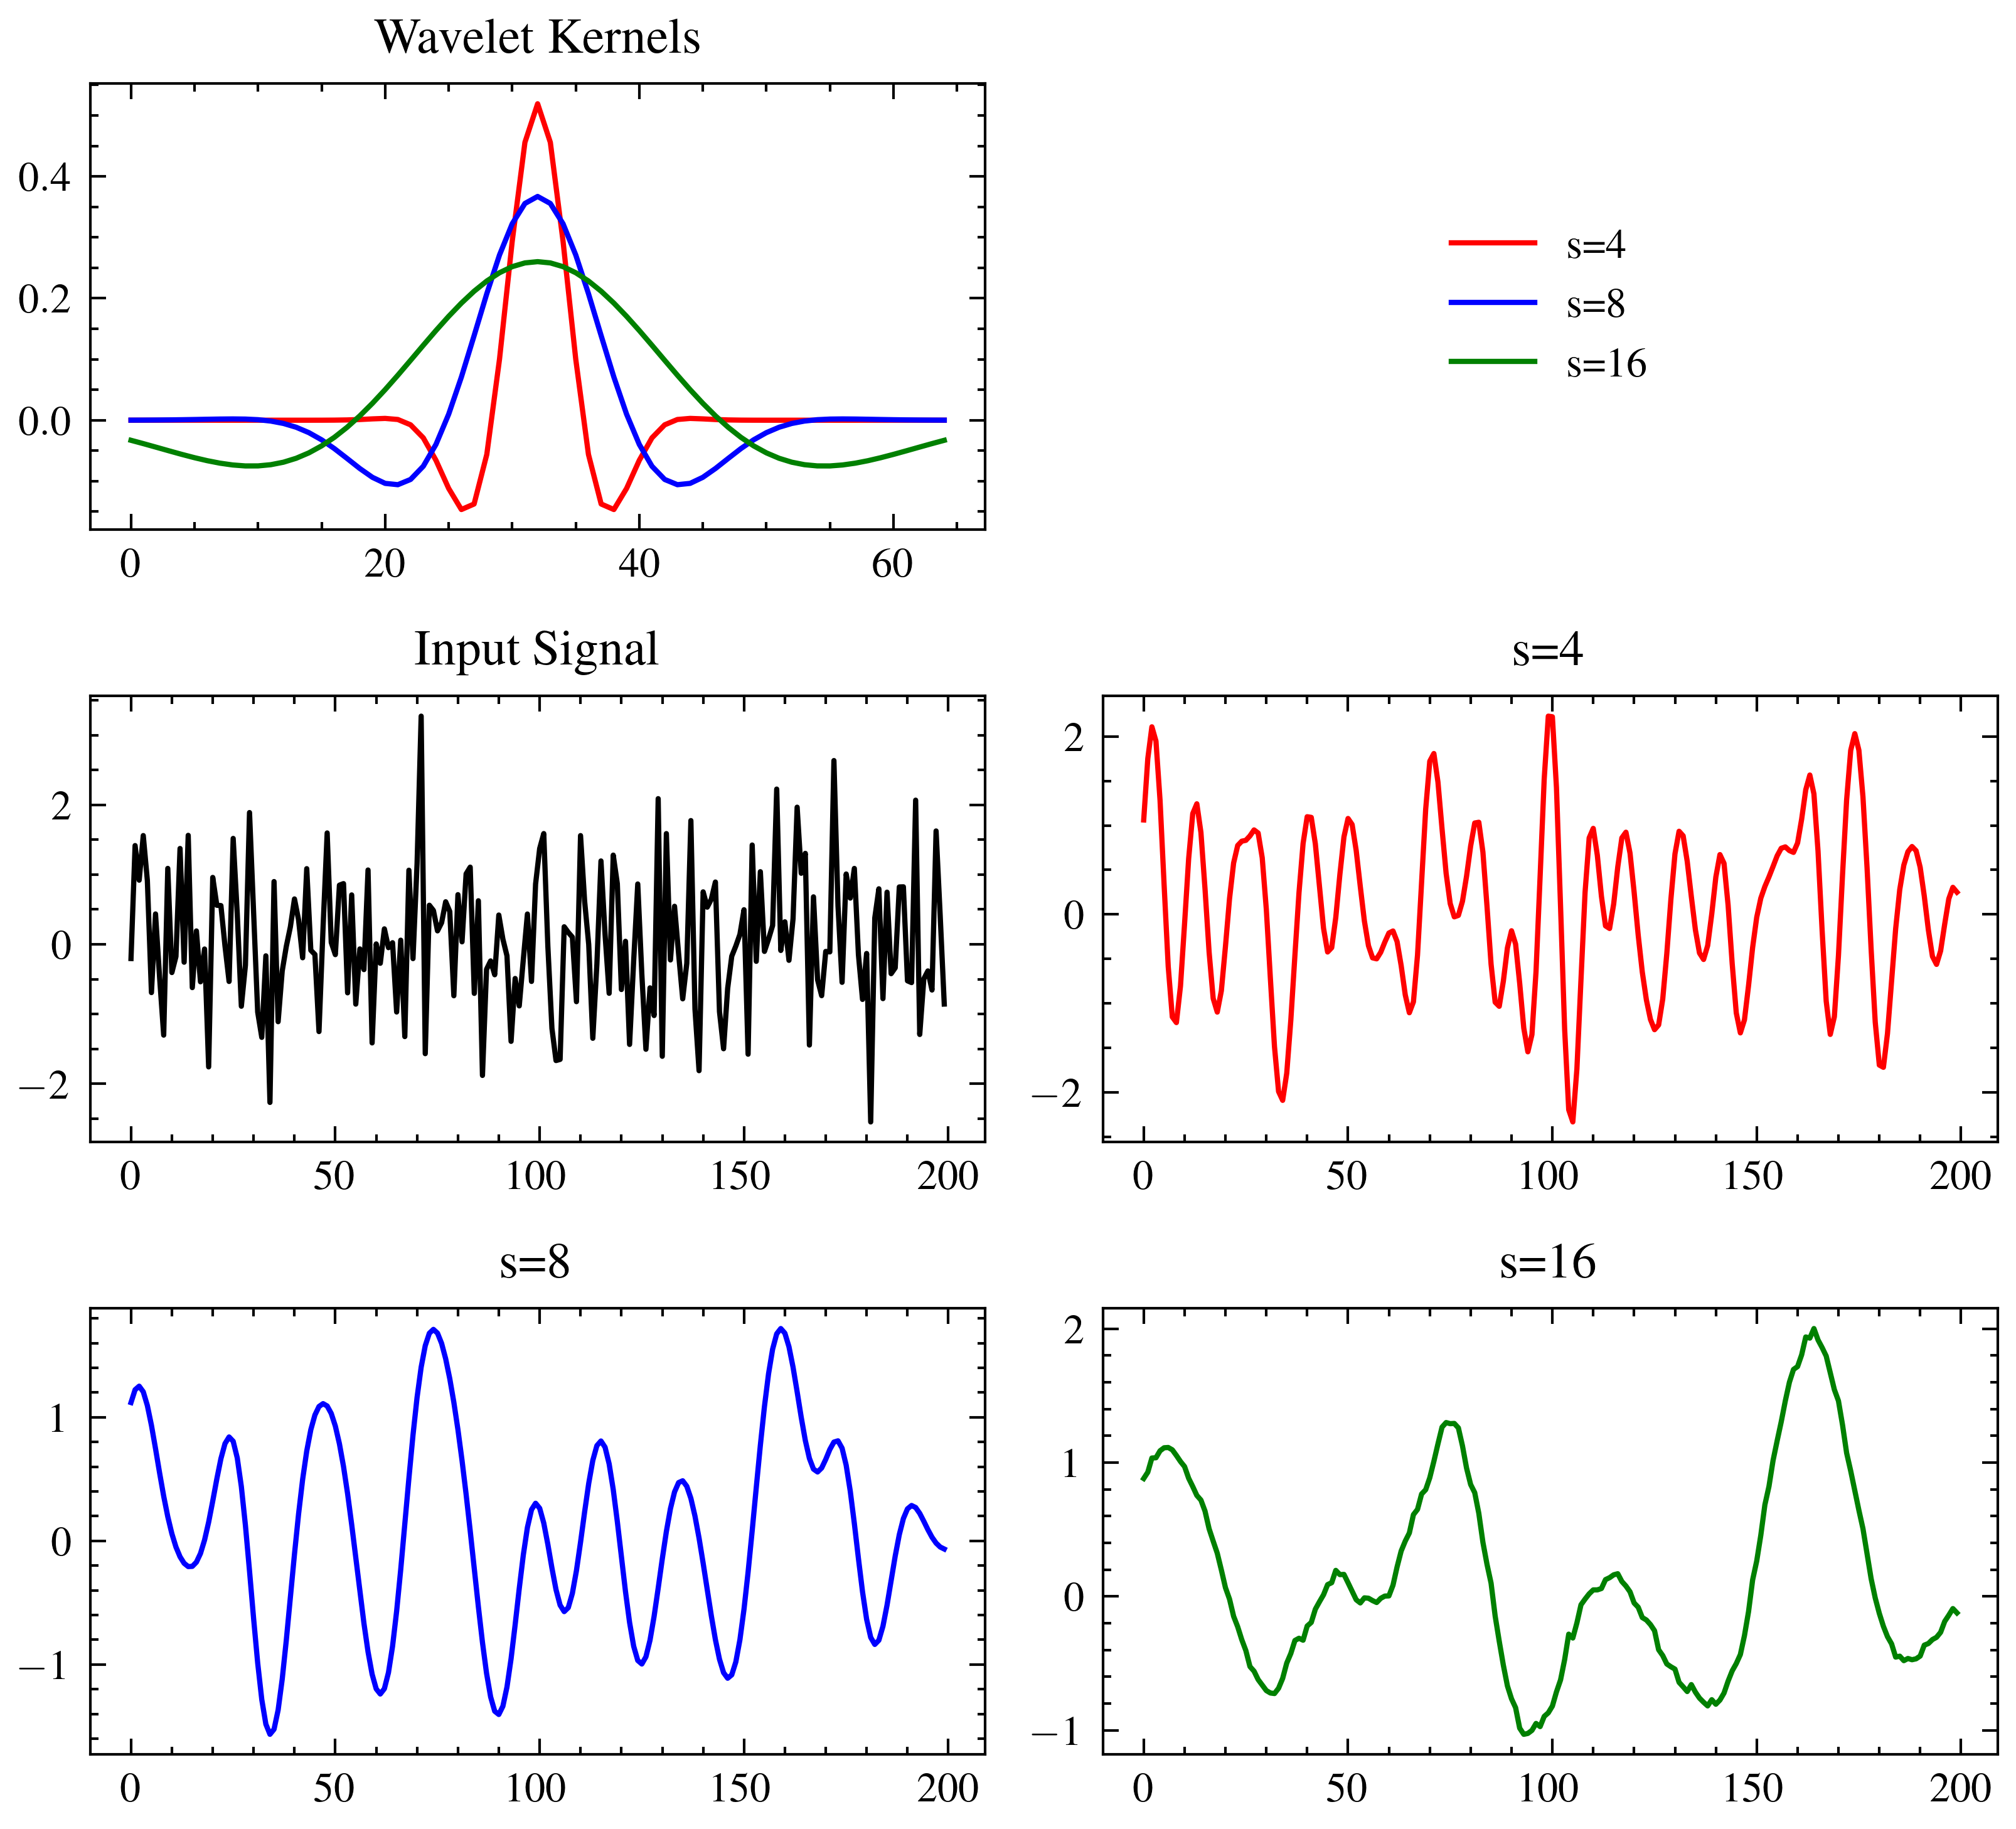

In [26]:
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scienceplots import plt
plt.style.use(['ieee'])


class WaveletVisualizer:
    def __init__(self, scales):
        self.scales = scales
        self.filters = self._create_filterbank(scales)

    def _create_filterbank(self, scales):
        max_scale = max(scales)
        t = torch.arange(-max_scale*2, max_scale*2+1, dtype=torch.float32)
        bank = []
        for s in scales:
            wavelet = torch.cos(1.75 * t / s) * torch.exp(-t**2 / (2 * s**2))
            wavelet /= wavelet.norm()
            bank.append(wavelet)
        return torch.stack(bank).view(len(scales), 1, -1)

    def _transform(self, x):
        x_flat = x.view(-1, 1, x.size(-1))
        x_conv = F.conv1d(x_flat, self.filters, padding='same')
        return x_conv.view(*x.shape[:-1], len(self.scales), x.size(-1))


# Create the visualizer and sample data
scales = [4, 8, 16]
visualizer = WaveletVisualizer(scales)
signal = torch.randn(1, 1, 200)  # 1 sample, 1 channel, 200 time points
transformed = visualizer._transform(signal)

# Setup figure with GridSpec: 3 rows x 2 columns.
fig = plt.figure(figsize=(5.5, 5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# --------------------------
# Top row: Wavelet Kernels + Legend
# --------------------------
# Left column: kernels plot
ax_kernels = fig.add_subplot(gs[0, 0])
colors = ['red', 'blue', 'green']
for i, s in enumerate(scales):
    kernel = visualizer.filters[i, 0].detach().numpy()
    ax_kernels.plot(kernel, color=colors[i], linestyle='solid', label=f's={s}')
ax_kernels.set_title('Wavelet Kernels')

# Right column: dedicated axis for legend (no actual plot)
ax_legend = fig.add_subplot(gs[0, 1])
ax_legend.axis('off')  # Hide axis frame and ticks
# Get the handles and labels from ax_kernels
handles, labels = ax_kernels.get_legend_handles_labels()
# Create the legend in this axis; it will be centered.
ax_legend.legend(handles, labels, loc='center', frameon=False)

# --------------------------
# Bottom 2x2 grid: Response plots
# --------------------------
# We'll create 4 subplots for the responses.
ax_in = fig.add_subplot(gs[1, 0])
ax_resp1 = fig.add_subplot(gs[1, 1])
ax_resp2 = fig.add_subplot(gs[2, 0])
ax_resp3 = fig.add_subplot(gs[2, 1])

# Plot the original signal in the top-left of the bottom grid
ax_in.plot(signal[0, 0].numpy())
ax_in.set_title('Input Signal')

# Plot the wavelet transform responses for each scale
ax_resp1.plot(transformed[0, 0, 0].detach().numpy(), color=colors[0])
ax_resp1.set_title('s=4')

ax_resp2.plot(transformed[0, 0, 1].detach().numpy(), color=colors[1])
ax_resp2.set_title('s=8')

ax_resp3.plot(transformed[0, 0, 2].detach().numpy(), color=colors[2])
ax_resp3.set_title('s=16')

plt.tight_layout()
# plt.show()
plt.savefig('doc/images/wavelet-transform.pdf', dpi=600)

# Eval Model

In [3]:
def load_ckpt(model_class, run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = model_class.load_from_checkpoint(ckpt_path)
    return model

In [4]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    plt.figure(figsize=(8, 3), dpi=600)
    for model_name, metrics in results.items():
        print(f"{model_name} - AUC: {metrics['roc_auc']:.4f}")
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.4f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
        #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    # plt.show()
    plt.savefig("doc/images/roc.pdf")

In [5]:
def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    num_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 2x3 grid

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for ax, (model_name, metrics) in zip(axes, results.items()):
        cm = metrics['confusion_matrix']

        if normalize:
            # Normalize by row (true class)
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'], ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{model_name} ($\\beta$={metrics["threshold"]:.4f})')
        ax.xaxis.set_tick_params(rotation=0)
        
    # Hide unused subplots
    for i in range(num_models, 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("doc/images/confusion.pdf", bbox_inches='tight', dpi=600)

In [6]:
import os
import numpy as np
import torch
from sklearn.metrics import (auc, confusion_matrix, roc_curve,
                             classification_report, f1_score)
from tqdm import tqdm


def compute_val_errors(model, val_loader):
    """Calculate reconstruction errors on interference-free validation data"""
    model.eval()
    errors = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Calculating Threshold"):
            x_time = batch['signal'].to(model.device)
            x_freq = batch['spectrum'].to(model.device)
            target = torch.cat([x_time, x_freq], dim=1)

            recon = model(x_time, x_freq)

            # Use same error calculation as during training
            if model.hparams.wavelet_scales is not None:
                # Wavelet-enhanced error calculation
                mse_error = F.mse_loss(recon, target, reduction='none')
                mse_per_sample = mse_error.mean([1, 2])

                wave_recon = model._wavelet_transform(recon)
                wave_target = model._wavelet_transform(target)
                wave_loss = 0.5 * F.mse_loss(wave_recon, wave_target,
                                             reduction='none').mean([1, 2, 3])
                error = mse_per_sample + wave_loss
            else:
                # Standard MSE error
                error = F.mse_loss(
                    recon, target, reduction='none').mean([1, 2])

            errors.extend(error.cpu().numpy())

    return np.array(errors)


def evaluate_model(model, test_loader, threshold):
    """Full evaluation with threshold on test set"""
    model.eval()
    errors = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            x_time = batch['signal'].to(model.device)
            x_freq = batch['spectrum'].to(model.device)
            target = torch.cat([x_time, x_freq], dim=1)
            labels = batch['label'].cpu().numpy()

            recon = model(x_time, x_freq)

            # Always use same error calculation as threshold determination
            if model.hparams.wavelet_scales is not None:
                mse_error = F.mse_loss(recon, target, reduction='none')
                mse_per_sample = mse_error.mean([1, 2])

                wave_recon = model._wavelet_transform(recon)
                wave_target = model._wavelet_transform(target)
                wave_loss = 0.5 * F.mse_loss(wave_recon, wave_target,
                                             reduction='none').mean([1, 2, 3])
                error = mse_per_sample + wave_loss
            else:
                error = F.mse_loss(
                    recon, target, reduction='none').mean([1, 2])

            errors.extend(error.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())

    errors = np.array(errors)
    labels = np.array(all_labels)
    preds = (errors > threshold).astype(int)

    # Compute metrics
    fpr, tpr, _ = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    return {
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(labels, preds),
        'classification_report': classification_report(labels, preds,
                                                       target_names=['Interference-free', 'Interference'], digits=4),
        'f1_score': f1_score(labels, preds),
    }


def count_flops(model, input_size=(32, 1, 800)):
    """Estimate model FLOPs"""
    from torchprofile import profile_macs
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Dummy input
    time_input = torch.randn(*input_size).to(device)
    freq_input = torch.randn(*input_size).to(device)

    flops = profile_macs(model, (time_input, freq_input))
    return flops

Calculating Threshold: 100%|██████████| 11/11 [00:00<00:00, 15.98it/s]


Full Model Threshold: 0.0001


Evaluating: 100%|██████████| 35/35 [00:00<00:00, 77.27it/s]
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pow". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


                   precision    recall  f1-score   support

Interference-free     0.8734    0.7567    0.8108      2252
     Interference     0.7825    0.8886    0.8322      2218

         accuracy                         0.8221      4470
        macro avg     0.8279    0.8226    0.8215      4470
     weighted avg     0.8283    0.8221    0.8214      4470



Calculating Threshold: 100%|██████████| 11/11 [00:00<00:00, 45.54it/s]


No Attention Threshold: 0.0002


Evaluating: 100%|██████████| 35/35 [00:00<00:00, 84.42it/s]
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pow". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


                   precision    recall  f1-score   support

Interference-free     0.8830    0.7607    0.8173      2252
     Interference     0.7870    0.8977    0.8387      2218

         accuracy                         0.8286      4470
        macro avg     0.8350    0.8292    0.8280      4470
     weighted avg     0.8353    0.8286    0.8279      4470



Calculating Threshold: 100%|██████████| 11/11 [00:00<00:00, 52.66it/s]


No Wavelet Threshold: 0.0002


Evaluating: 100%|██████████| 35/35 [00:00<00:00, 88.81it/s]
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pow". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


                   precision    recall  f1-score   support

Interference-free     0.8824    0.7527    0.8124      2252
     Interference     0.7815    0.8981    0.8357      2218

         accuracy                         0.8248      4470
        macro avg     0.8319    0.8254    0.8241      4470
     weighted avg     0.8323    0.8248    0.8240      4470



Calculating Threshold: 100%|██████████| 11/11 [00:00<00:00, 56.90it/s]


Baseline Threshold: 0.0002


Evaluating: 100%|██████████| 35/35 [00:00<00:00, 92.39it/s]
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pow". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


                   precision    recall  f1-score   support

Interference-free     0.8859    0.7553    0.8154      2252
     Interference     0.7839    0.9013    0.8385      2218

         accuracy                         0.8277      4470
        macro avg     0.8349    0.8283    0.8270      4470
     weighted avg     0.8353    0.8277    0.8269      4470

Full Model - AUC: 0.9275
No Attention - AUC: 0.9294
No Wavelet - AUC: 0.9283
Baseline - AUC: 0.9297


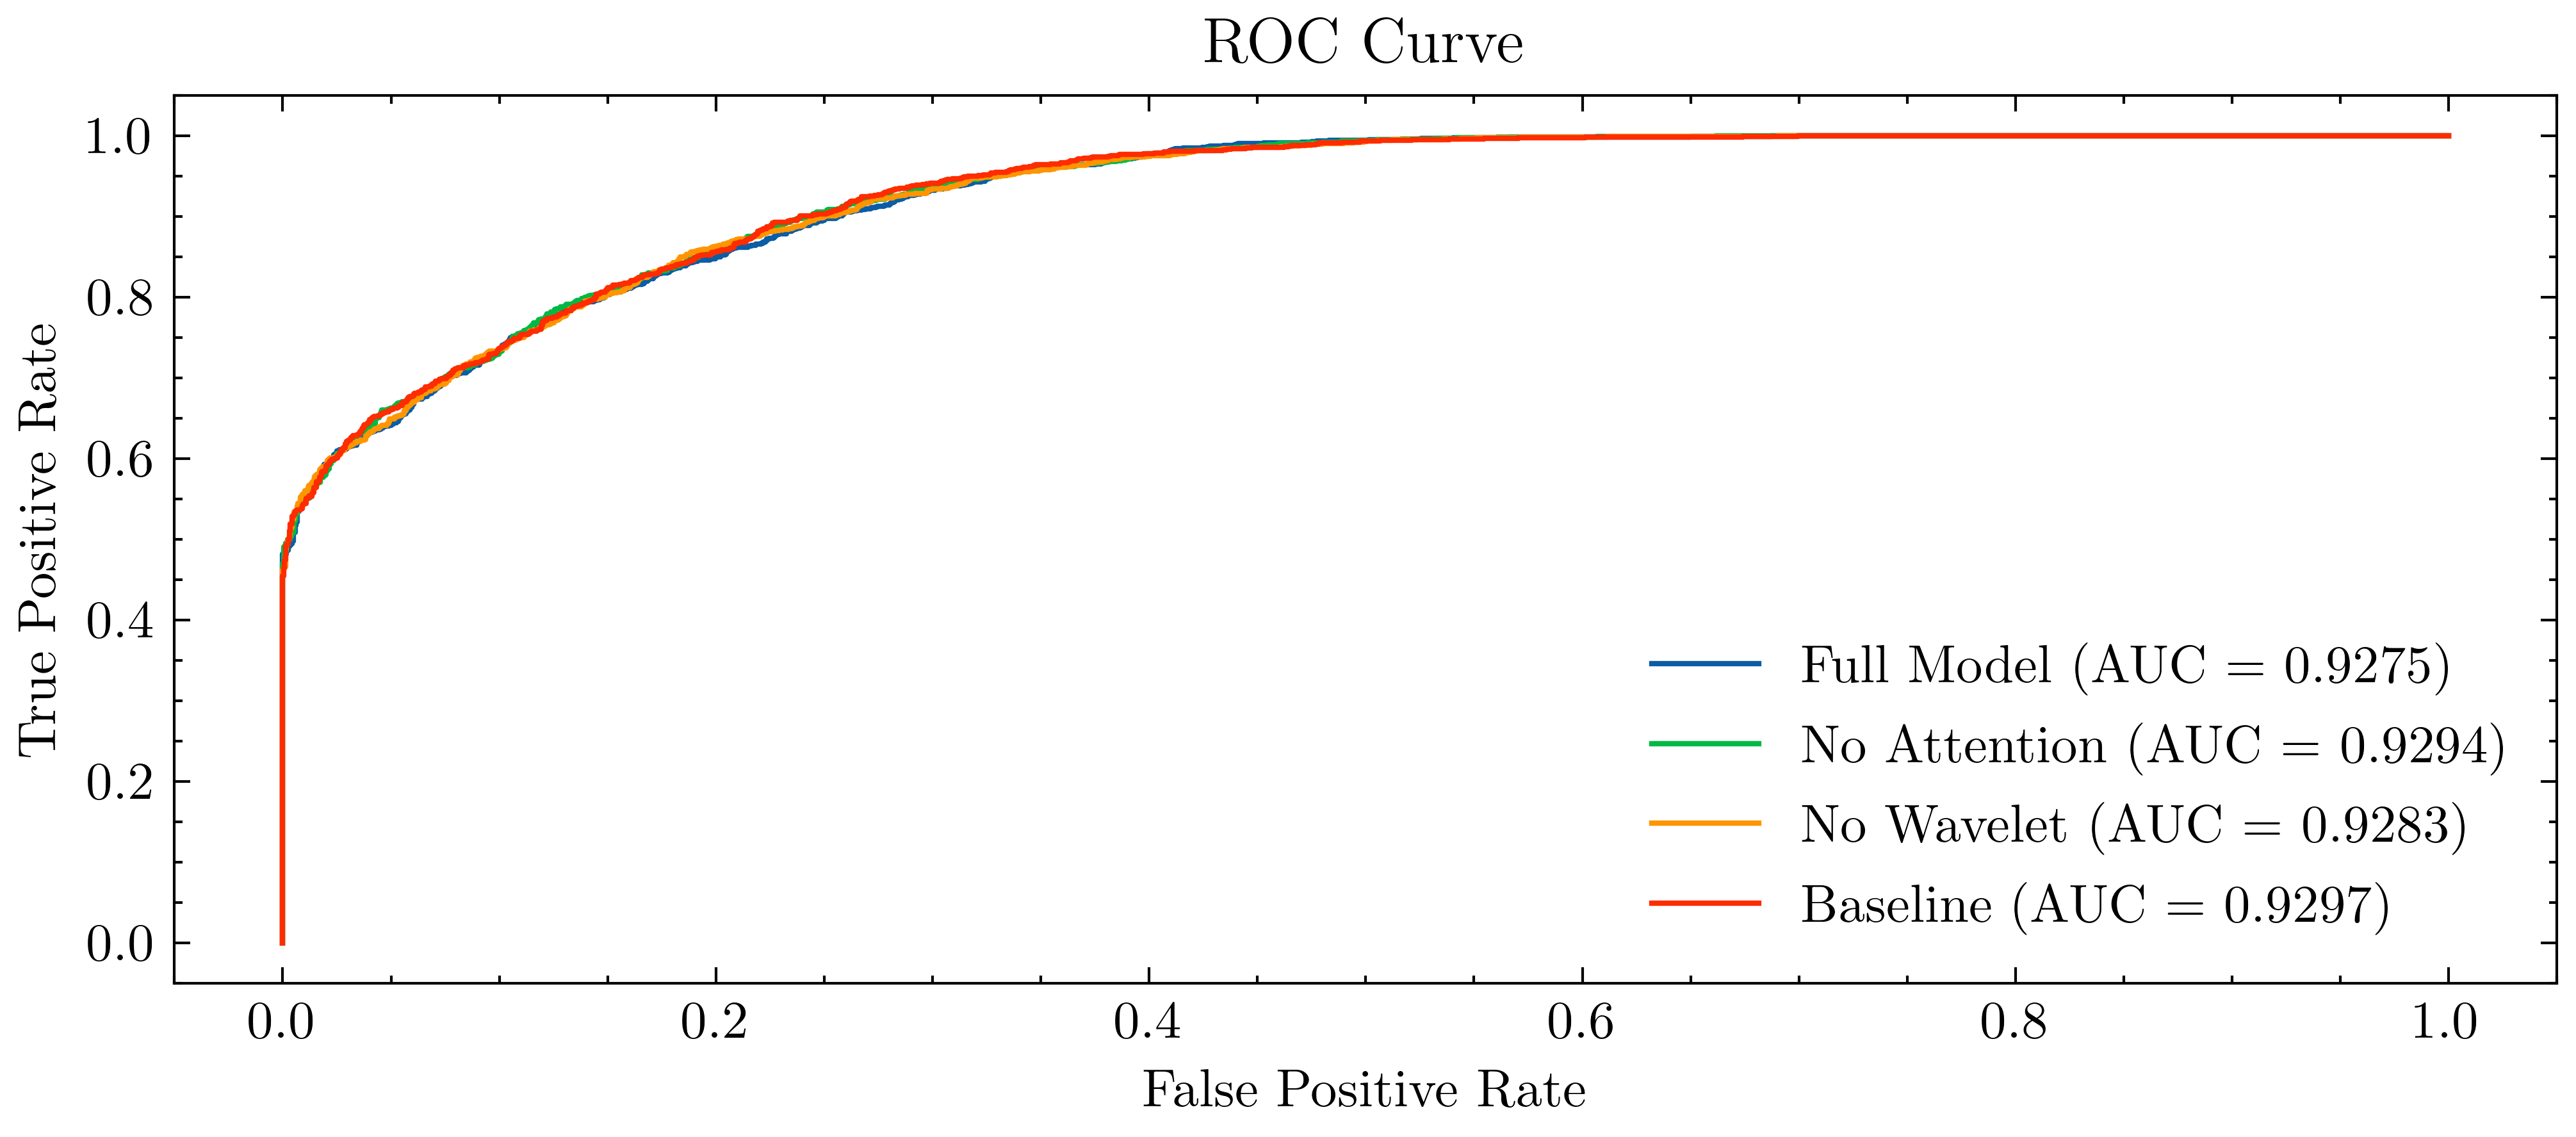

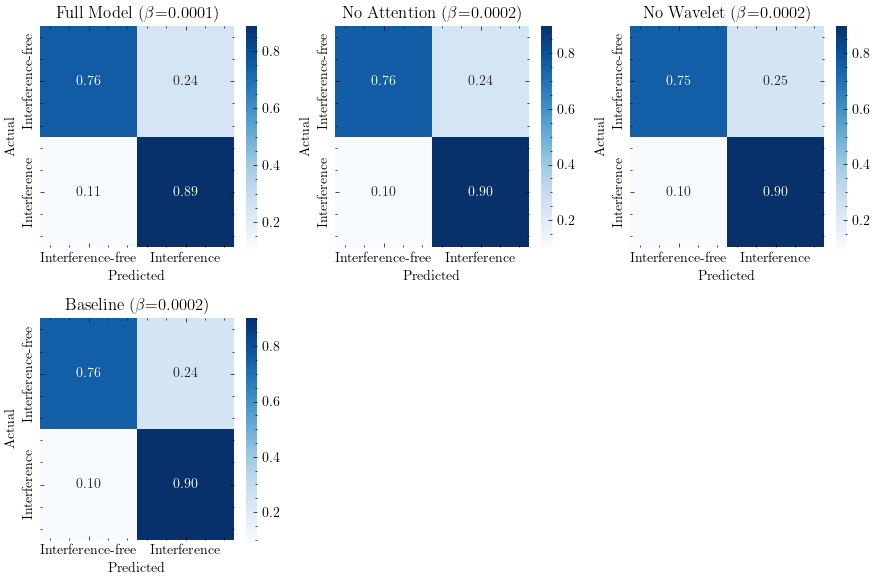

In [7]:
from data_modules import BaseDataModule
from ablation import Conv_Att_Wave_Net
import os
import pickle
import numpy as np

# Initialize data module
data_module = BaseDataModule(batch_size=128)
data_module.prepare_data()

# Get validation loader (only interference-free)
data_module.setup(stage="fit")
val_loader = data_module.val_dataloader()

# Get test loader (both classes)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

# Model checkpoints (update with your paths)
model_configs = [
    # ('Full Model', '1lmrknhq', 'ab_1_epoch=297-step=26820-val_loss=0.00.ckpt'),
    ('Full Model', 'ksnx9407', 'ab_1_epoch=446-step=40230-val_loss=0.00.ckpt'),
    ('No Attention', '2c5m5c62', 'ab_2_epoch=278-step=25110-val_loss=0.00.ckpt'),
    ('No Wavelet', 'qmhci7pw', 'ab_3_epoch=298-step=26910-val_loss=0.00.ckpt'),
    ('Baseline', 'gtkkvuma', 'ab_4_epoch=287-step=25920-val_loss=0.00.ckpt')
]

results = {}
for model_name, exp_name, ckpt_name in model_configs:
    # Load model
    model = load_ckpt(Conv_Att_Wave_Net, exp_name, ckpt_name)
    # Calculate threshold using validation set
    val_errors = compute_val_errors(model, val_loader)
    threshold = np.mean(val_errors) + 0.5 * np.std(val_errors)
    print(f"{model_name} Threshold: {threshold:.4f}")

    # Full evaluation
    metrics = evaluate_model(model, test_loader, threshold)

    # Add model complexity metrics
    metrics['flops'] = count_flops(model)
    metrics['params'] = sum(p.numel() for p in model.parameters())
    print(metrics['classification_report'])
    results[model_name] = metrics

    filename = f"results/{model_name}_results.pkl"
    with open(filename, 'wb') as f:
        pickle.dump({
            "name": model_name,
            'tpr': metrics['tpr'],
            'fpr': metrics['fpr'],
            'roc_auc': metrics['roc_auc'],
            'threshold': metrics['threshold'],
        }, f)

# Generate comparison plots
plot_comparative_roc(results)
plot_comparative_confusion_matrices(results)

# Graph from pickle results

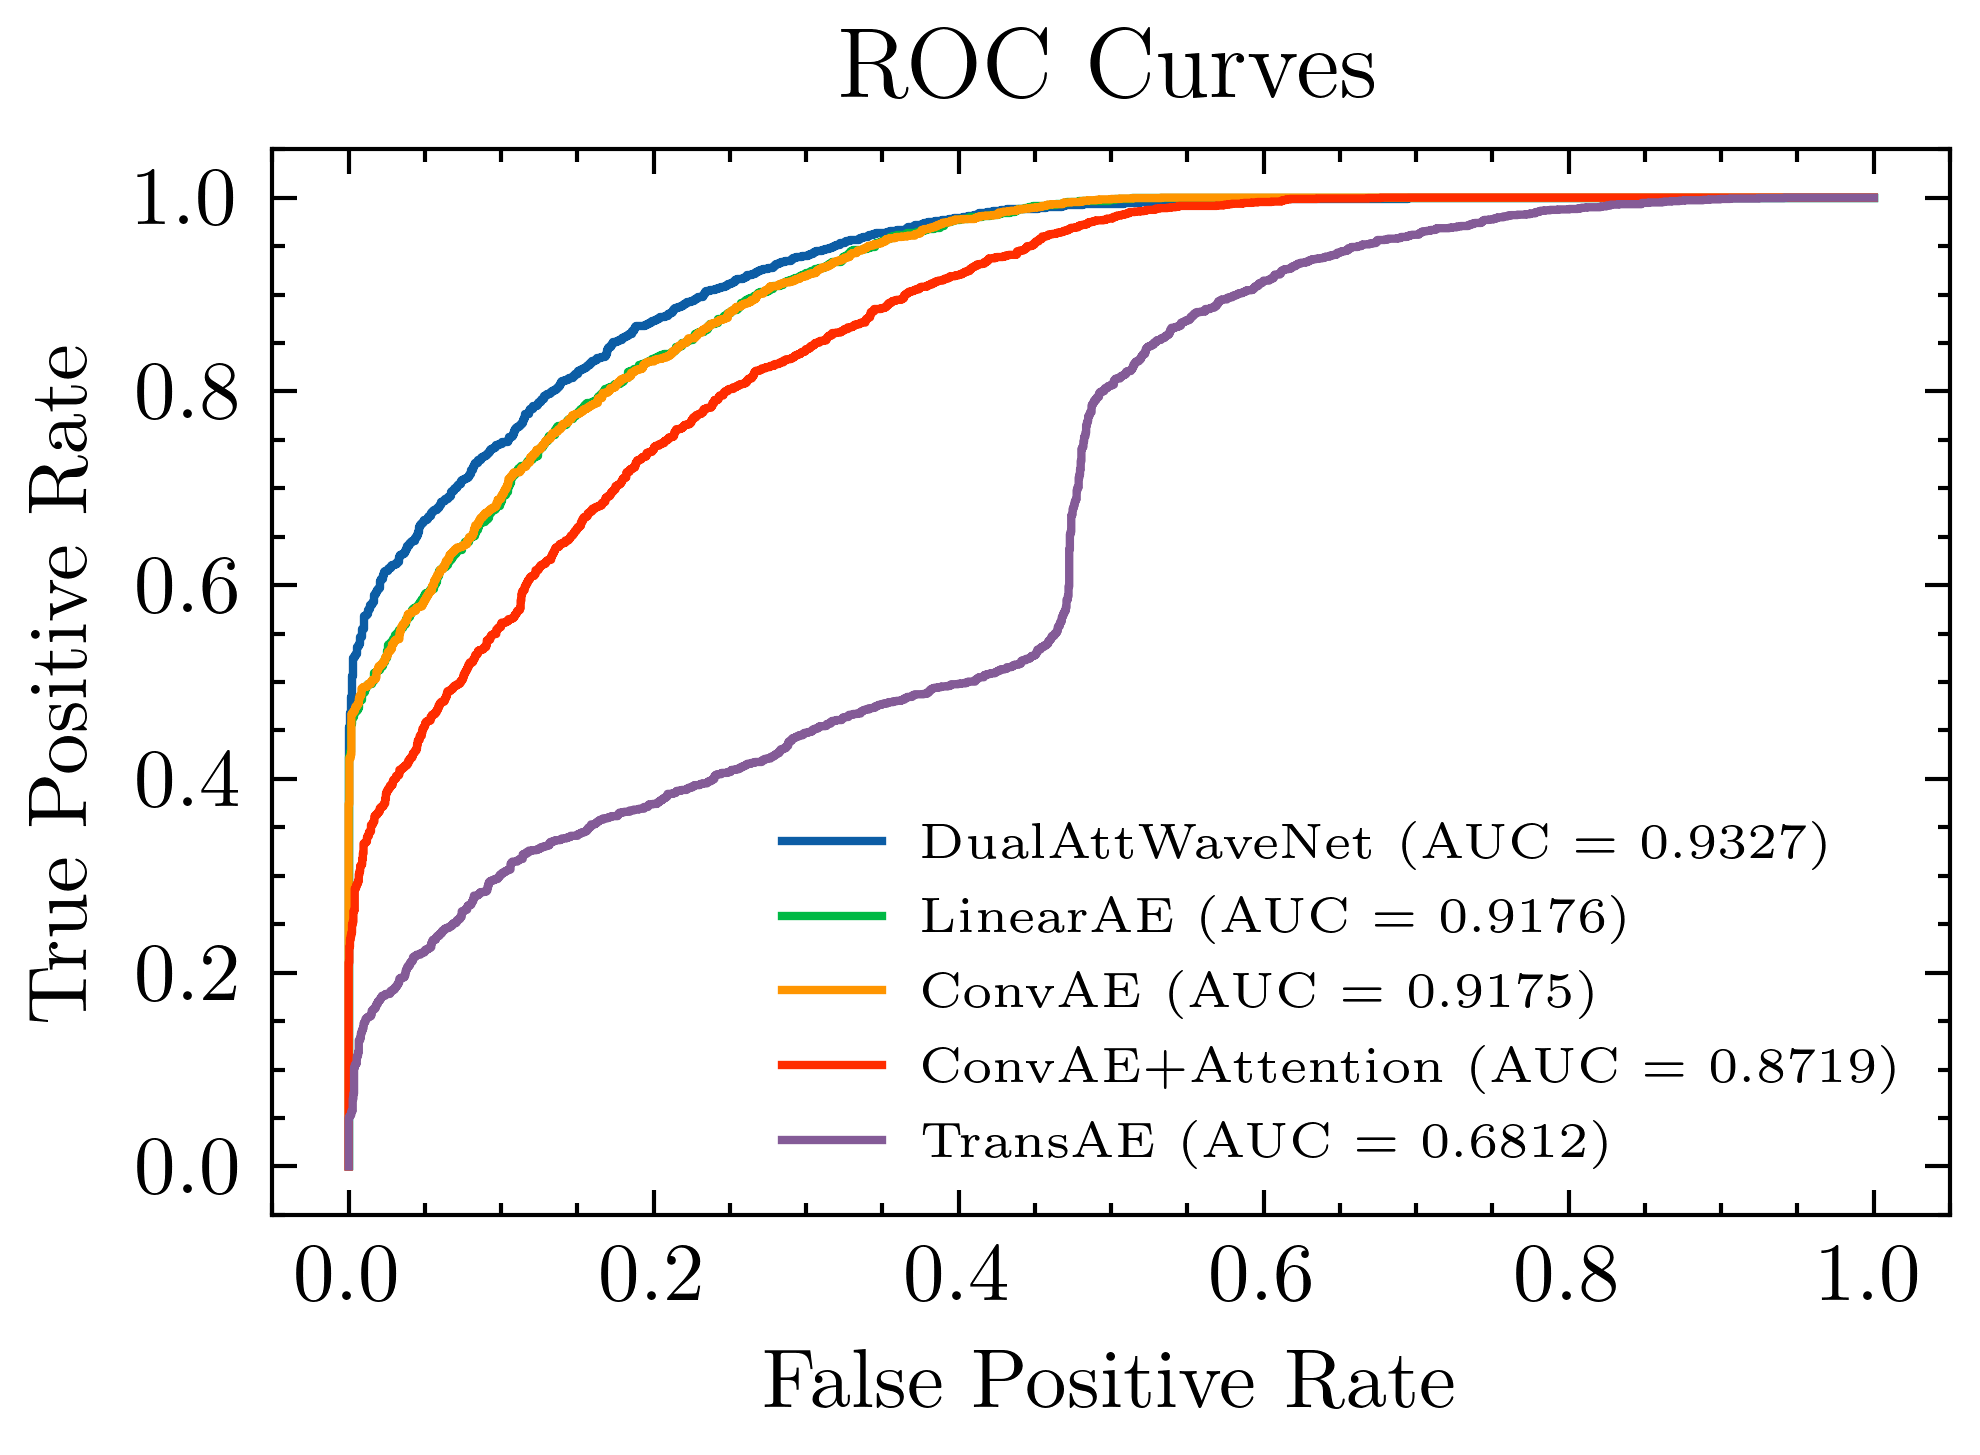

In [9]:
def load_roc_data(class_names, load_dir='results'):
    """Load ROC data for specified classes"""
    loaded_data = {}

    for cls in class_names:
        filename = os.path.join(load_dir, f'{cls}_results.pkl')
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            loaded_data[cls] = data

    return loaded_data


def plot_auc_curve(class_names, load_dir='results'):
    roc_data = load_roc_data(class_names, load_dir)

    plt.figure(dpi=600)
    for cls, data in roc_data.items():
        if cls == "CDMA_Net":
            cls = "DualAttWaveNet"
        elif cls == "CNNAE":
            cls = "ConvAE"
        elif cls == "CNNAEAttention":
            cls = "ConvAE+Attention"
        elif cls == "TransformerAE":
            cls = "TransAE"
        plt.plot(data['fpr'], data['tpr'],
                 label=f'{cls} (AUC = {data["roc_auc"]:.4f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.savefig("doc/images/roc-comparison.pdf")


plot_auc_curve(['CDMA_Net', 'LinearAE', 'CNNAE', 'CNNAEAttention', 'TransformerAE'])

# Signal Input and output